In [ ]:
#Kütüphaneler ve ayarlar
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

#Tekrarlanabilirlik (Seed)
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

#Cihaz ayarı
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {DEVICE}")

#Hiperparametreler
BATCH_SIZE = 32
EPOCHS = 20  #VGG büyük olduğu için epoch sayısı artabilir ama 20 ideal.
LR = 1e-4    #VGG için düşük öğrenme oranı iyidir.
PATIENCE = 5 #Erken durdurma sabrı
IMG_SIZE = 224 #VGG standart giriş boyutu

Kullanılan Cihaz: cpu


In [ ]:
#Veri yollarını okuma
DATA_DIR = "dataset" #Veri setinin olduğu klasör

#Sınıf isimlerini al
class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print(f"Sınıflar: {class_names}")

#Tüm resim yollarını ve etiketleri topla
image_paths = []
image_labels = []

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_file in os.listdir(class_dir):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_dir, img_file))
            image_labels.append(label)

print(f"Toplam Görüntü Sayısı: {len(image_paths)}")

Sınıflar: ['Cloudy', 'Rain', 'Shine', 'Sunrise']
Toplam Görüntü Sayısı: 1125


In [ ]:
#Veri bölme ve dönüşümler

#Veriyi Bölme: %70 Eğitim, %15 Doğrulama, %15 Test
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, image_labels, test_size=0.3, stratify=image_labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Eğitim: {len(X_train)}, Doğrulama: {len(X_val)}, Test: {len(X_test)}")

#Transformlar (Augmentation eklendi)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),    #Rastgele yatay çevir
    transforms.RandomRotation(15),        #Rastgele döndür
    transforms.ColorJitter(brightness=0.1, contrast=0.1), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Eğitim: 787, Doğrulama: 169, Test: 169


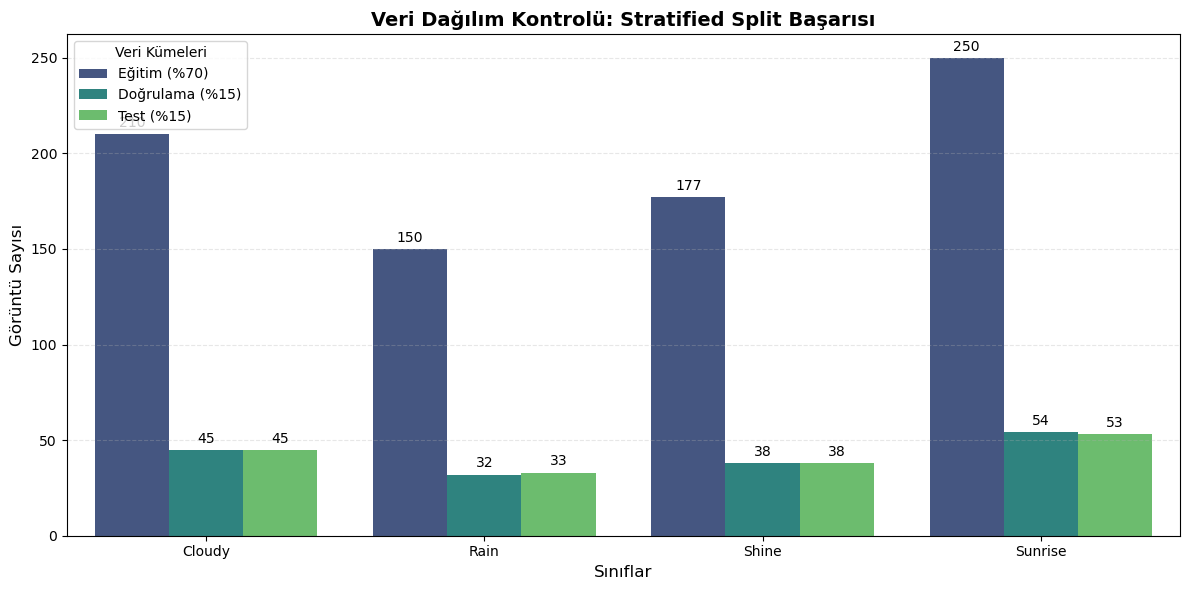

In [ ]:
#Veri dağılımı kontrolü (Grafik)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

#Her kümedeki etiket sayılarını hesapla
# y_train, y_val, y_test listeleri Hücre 3'ten geliyor
train_counts = Counter(y_train)
val_counts = Counter(y_val)
test_counts = Counter(y_test)

#Veriyi tablo haline getir (DataFrame)
data = []
for i, class_name in enumerate(class_names):
    #Train bilgisini ekle
    data.append({'Sınıf': class_name, 'Küme': 'Eğitim (%70)', 'Adet': train_counts[i]})
    #Val bilgisini ekle
    data.append({'Sınıf': class_name, 'Küme': 'Doğrulama (%15)', 'Adet': val_counts[i]})
    #Test bilgisini ekle
    data.append({'Sınıf': class_name, 'Küme': 'Test (%15)', 'Adet': test_counts[i]})

df_dagilim = pd.DataFrame(data)

#Grafiği çiz
plt.figure(figsize=(12, 6))
sns.barplot(data=df_dagilim, x='Sınıf', y='Adet', hue='Küme', palette='viridis')

plt.title('Veri Dağılım Kontrolü: Stratified Split Başarısı', fontsize=14, fontweight='bold')
plt.xlabel('Sınıflar', fontsize=12)
plt.ylabel('Görüntü Sayısı', fontsize=12)
plt.legend(title='Veri Kümeleri')
plt.grid(axis='y', linestyle='--', alpha=0.3)

#Çubukların üzerine sayıları yaz
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', padding=3)

plt.tight_layout()
plt.show()

In [ ]:
#Dataset sınıfı ve dataLoader
class WeatherDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

#Datasetleri oluştur
train_dataset = WeatherDataset(X_train, y_train, transform=train_transforms)
val_dataset = WeatherDataset(X_val, y_val, transform=test_transforms)
test_dataset = WeatherDataset(X_test, y_test, transform=test_transforms)

#DataLoaderları oluştur
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
#Model kurulumu (VGG16)
def get_vgg16_model(num_classes):
    print("VGG16 Modeli İndiriliyor...")
    #Pretrained ağırlıklarla yükle
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    
    #Sınıflandırıcıyı değiştir
    #VGG16'nın classifier bloğunun son katmanı 6. indistir.
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)
    
    return model.to(DEVICE)

model = get_vgg16_model(len(class_names))

#Hata fonksiyonu ve optimizasyon
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

#Scheduler (Dinamik azaltma)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

VGG16 Modeli İndiriliyor...


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
#Eğitim ve değerlendirme fonksiyonları
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
    return running_loss / len(loader), correct / total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    return running_loss / len(loader), correct / total

In [ ]:
#Ana eğitim döngüsü
best_val_acc = 0.0
patience_counter = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Eğitim Başlıyor...")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    #Öğrenme oranını güncelle 
    scheduler.step(val_acc)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    #En iyi modeli kaydet
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vgg16.pth")
        patience_counter = 0
        print("  --> En iyi model kaydedildi!")
    else:
        patience_counter += 1
        print(f"  --> İyileşme yok. Sabır: {patience_counter}/{PATIENCE}")
        
    if patience_counter >= PATIENCE:
        print("Erken Durdurma Tetiklendi!")
        break

Eğitim Başlıyor...
Epoch 1/20 - Train Loss: 0.4661, Train Acc: 0.8221 | Val Loss: 0.1986, Val Acc: 0.9231
  --> En iyi model kaydedildi!
Epoch 2/20 - Train Loss: 0.1316, Train Acc: 0.9568 | Val Loss: 0.1589, Val Acc: 0.9586
  --> En iyi model kaydedildi!
Epoch 3/20 - Train Loss: 0.0457, Train Acc: 0.9924 | Val Loss: 0.1085, Val Acc: 0.9704
  --> En iyi model kaydedildi!
Epoch 4/20 - Train Loss: 0.0190, Train Acc: 0.9936 | Val Loss: 0.1494, Val Acc: 0.9645
  --> İyileşme yok. Sabır: 1/5
Epoch 5/20 - Train Loss: 0.0134, Train Acc: 0.9962 | Val Loss: 0.1483, Val Acc: 0.9704
  --> İyileşme yok. Sabır: 2/5
Epoch 6/20 - Train Loss: 0.0747, Train Acc: 0.9822 | Val Loss: 0.1951, Val Acc: 0.9349
  --> İyileşme yok. Sabır: 3/5
Epoch 7/20 - Train Loss: 0.0399, Train Acc: 0.9860 | Val Loss: 0.0895, Val Acc: 0.9704
  --> İyileşme yok. Sabır: 4/5
Epoch 8/20 - Train Loss: 0.0237, Train Acc: 0.9924 | Val Loss: 0.0870, Val Acc: 0.9704
  --> İyileşme yok. Sabır: 5/5
Erken Durdurma Tetiklendi!


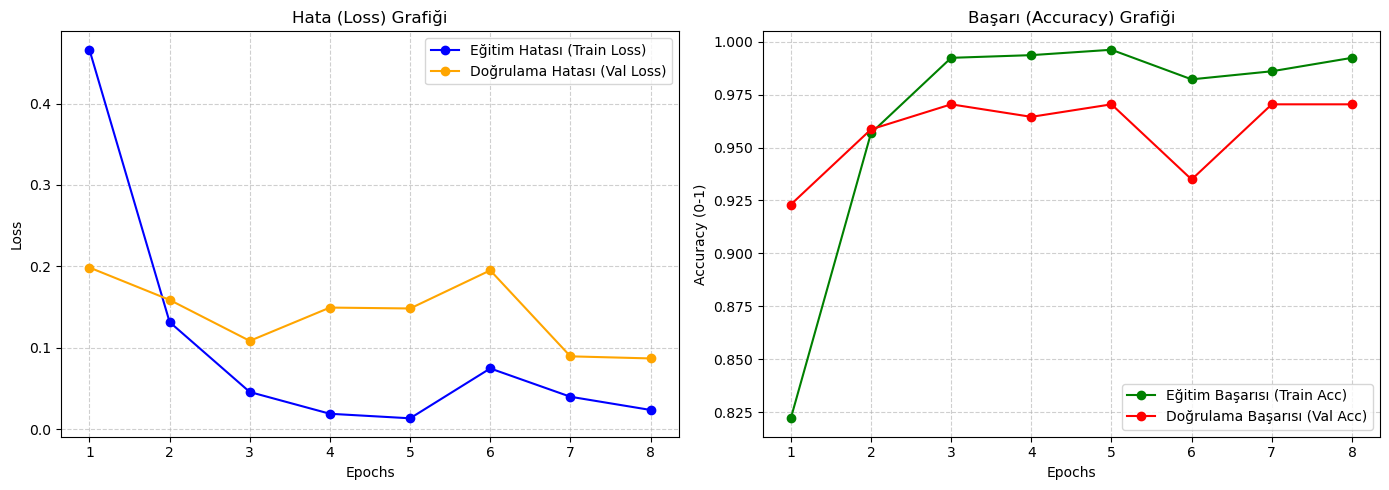

In [ ]:
#Eğitim sonuçlarını görselleştirme (Loss & Accuracy)
import matplotlib.pyplot as plt

#History verilerini değişkenlere alalım
train_losses = history['train_loss']
val_losses = history['val_loss']
train_accs = history['train_acc']
val_accs = history['val_acc']

#Eğitim kaç epoch sürdüyse ona göre x ekseni oluştur
epochs_ran = range(1, len(train_losses) + 1)

#LOSS (Hata) değişimi
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_ran, train_losses, '-o', label='Eğitim Hatası (Train Loss)', color='blue')
plt.plot(epochs_ran, val_losses, '-o', label='Doğrulama Hatası (Val Loss)', color='orange')
plt.title('Hata (Loss) Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

#ACCURACY (Başarı) değişimi
plt.subplot(1, 2, 2)
plt.plot(epochs_ran, train_accs, '-o', label='Eğitim Başarısı (Train Acc)', color='green')
plt.plot(epochs_ran, val_accs, '-o', label='Doğrulama Başarısı (Val Acc)', color='red')
plt.title('Başarı (Accuracy) Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (0-1)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

/var/folders/q_/sjb73cls7qg8129c74d5cb3m0000gn/T/ipykernel_13042/664859703.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vgg16.p


Test Doğruluğu: 0.9763

Sınıflandırma Raporu:
              precision    recall  f1-score   support

      Cloudy       0.94      0.98      0.96        45
        Rain       1.00      1.00      1.00        33
       Shine       0.97      0.92      0.95        38
     Sunrise       1.00      1.00      1.00        53

    accuracy                           0.98       169
   macro avg       0.98      0.97      0.98       169
weighted avg       0.98      0.98      0.98       169



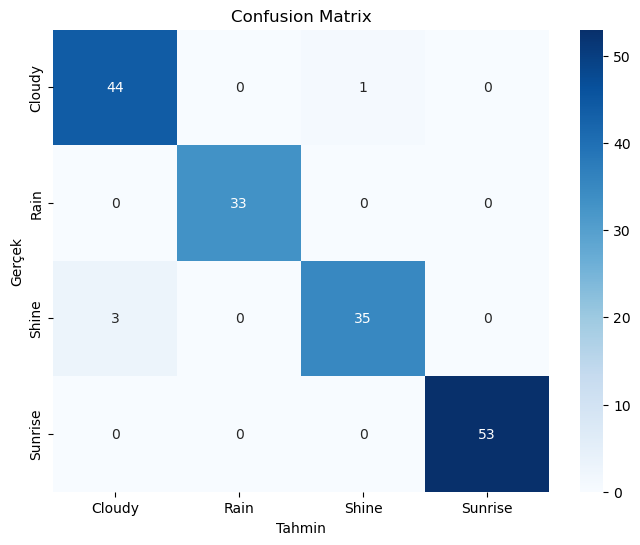

Model Tahmin Örnekleri:


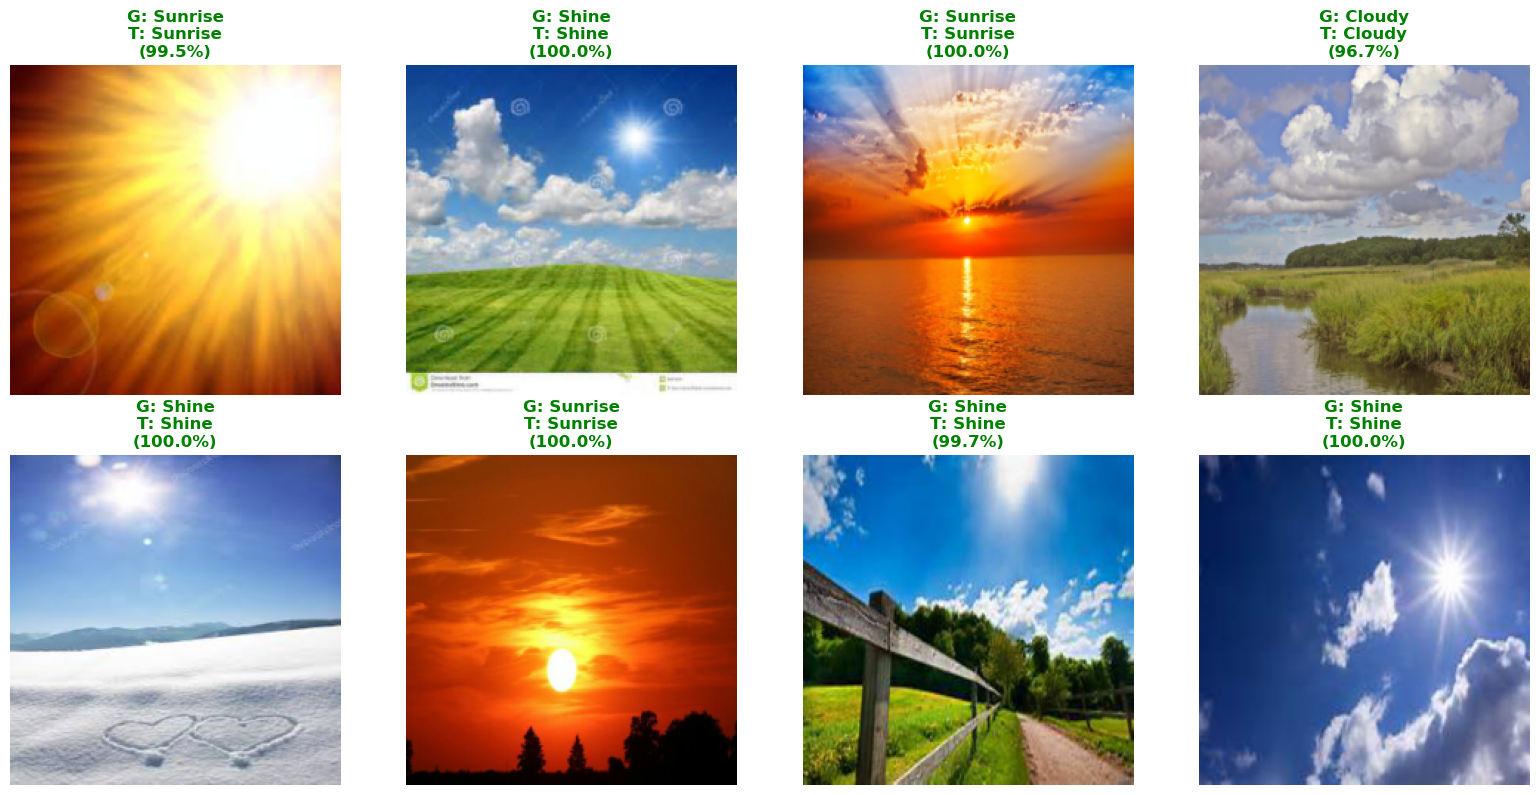

In [ ]:
#Test ve sonuç gösterimi

#En iyi modeli geri yükle
model.load_state_dict(torch.load("best_vgg16.pth"))
model.eval()

#Test seti değerlendirmesi
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"\nTest Doğruluğu: {test_acc:.4f}")

#Raporlama
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=class_names))

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

#Görsel analiz
def denormalize(tensor):
    """Normalize edilmiş tensörü orijinal haline çevirir"""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = tensor.cpu().permute(1, 2, 0).numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

def show_samples(model, loader, n=8):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images[:n].to(DEVICE), labels[:n].to(DEVICE)
    
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        
    plt.figure(figsize=(16, 8))
    for i in range(n):
        img = denormalize(images[i])
        true_label = class_names[labels[i].item()]
        pred_label = class_names[preds[i].item()]
        prob = probs[i][preds[i]].item()
        
        #Tahmin doğruysa Yeşil, yanlışsa Kırmızı
        color = 'green' if true_label == pred_label else 'red'
        
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(f"G: {true_label}\nT: {pred_label}\n({prob:.1%})", color=color, fontsize=12, fontweight='bold')
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

print("Model Tahmin Örnekleri:")
show_samples(model, test_loader)

ROC Eğrisi için olasılıklar hesaplanıyor...


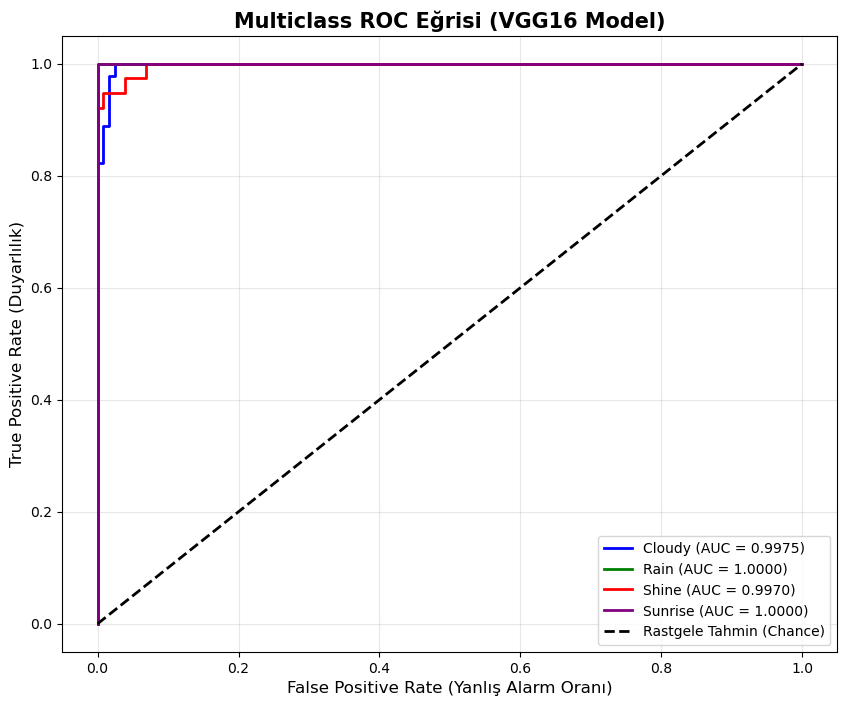

In [ ]:
#ROC eğrisi ve AUC hesaplama (VGG16 Analizi)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import torch

#Test verisi üzerindeki OLASILIKLARI (Probabilities) al
model.eval()
y_test_true = []
y_test_probs = []

print("ROC Eğrisi için olasılıklar hesaplanıyor...")

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        #Çıktıları olasılığa çevir (Softmax)
        probs = torch.softmax(outputs, dim=1)
        
        y_test_probs.extend(probs.cpu().numpy())
        y_test_true.extend(labels.cpu().numpy())

y_test_true = np.array(y_test_true)
y_test_probs = np.array(y_test_probs)

# Etiketleri Binarize Et (Örn: 2 -> [0, 0, 1, 0] formatına çevir)
#ROC eğrisi her sınıf için "O Sınıf vs Diğerleri" mantığıyla çizilir.
n_classes = len(class_names)
y_true_bin = label_binarize(y_test_true, classes=list(range(n_classes)))

#Grafiği çiz
plt.figure(figsize=(10, 8))

#Her sınıf için ayrı ayrı eğri çiz
colors = ['blue', 'green', 'red', 'purple', 'orange'] # Sınıf sayısına göre renkler
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_test_probs[:, i])
    roc_auc = auc(fpr, tpr)
    #Renk listesinden renk seç, yetmezse döngüye girer
    color = colors[i % len(colors)]
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.4f})')

#Referans çizgisi (Rastgele tahmin çizgisi - %50 şans)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Rastgele Tahmin (Chance)')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate (Yanlış Alarm Oranı)', fontsize=12)
plt.ylabel('True Positive Rate (Duyarlılık)', fontsize=12)
plt.title('Multiclass ROC Eğrisi (VGG16 Model)', fontsize=15, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

ROC Analizi için olasılıklar hesaplanıyor...


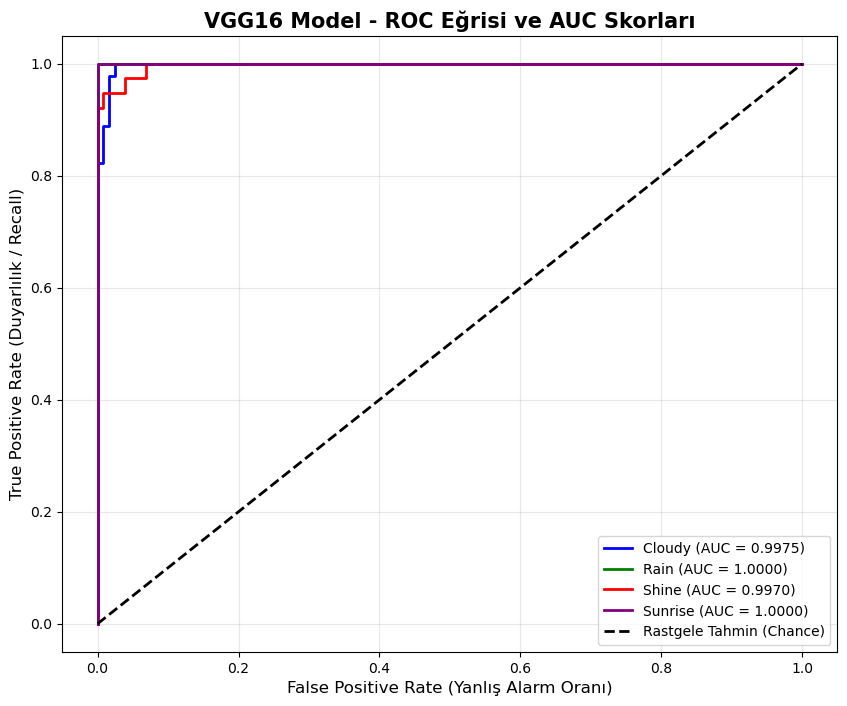

In [ ]:
#ROC eğrisi ve AUC hesaplama
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import torch

#Test verisi üzerindeki OLASILIKLARI (Probabilities) al
model.eval()
y_test_true = []
y_test_probs = []

print("ROC Analizi için olasılıklar hesaplanıyor...")

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        #Çıktıları olasılığa çevir (Softmax)
        #Modelin "bu resim %90 Cloudy, %10 Rain" dediği oranları alıyoruz
        probs = torch.softmax(outputs, dim=1)
        
        y_test_probs.extend(probs.cpu().numpy())
        y_test_true.extend(labels.cpu().numpy())

y_test_true = np.array(y_test_true)
y_test_probs = np.array(y_test_probs)

#Etiketleri Binarize Et (One-Hot Encoding)
#Örn: 2 (Rain) -> [0, 0, 1, 0] formatına çevrilir.
#Bu işlem, çok sınıflı (multiclass) ROC çizimi için zorunludur.
n_classes = len(class_names)
y_true_bin = label_binarize(y_test_true, classes=list(range(n_classes)))

#Grafiği çiz
plt.figure(figsize=(10, 8))

#Her sınıf için ayrı ayrı eğri çiz
colors = ['blue', 'green', 'red', 'purple', 'orange'] # Sınıflar için renk havuzu

for i in range(n_classes):
    #False Positive Rate ve True Positive Rate hesapla
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_test_probs[:, i])
    
    #AUC (Eğri Altındaki Alan) değerini hesapla
    roc_auc = auc(fpr, tpr)
    
    #Rengi seç (sınıf sayısına göre döngüsel)
    color = colors[i % len(colors)]
    
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.4f})')

#Referans çizgisi (Rastgele tahmin çizgisi - %50 başarı)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Rastgele Tahmin (Chance)')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate (Yanlış Alarm Oranı)', fontsize=12)
plt.ylabel('True Positive Rate (Duyarlılık / Recall)', fontsize=12)
plt.title('VGG16 Model - ROC Eğrisi ve AUC Skorları', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()